In [1]:
import pandas as pd
import xarray as xr
import numpy as np

In [2]:
import datetime

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [4]:
path_data = 'C:/Users/Alberto/Desktop/Crypto prediction/Data/Raw/'
data_file_name = 'btcusd.csv'
data = pd.read_csv(path_data + data_file_name)

### Index time

In [5]:
def from_unix_to_datetime(unix_time):
    return datetime.datetime.fromtimestamp(int(unix_time))

In [6]:
def to_str(element):
    return str(element)[:10]

In [7]:
data['Time'] = data['time'].apply(to_str).apply(from_unix_to_datetime)

In [8]:
data.pop('time')

0          1364774820000
1          1364774880000
2          1364774940000
3          1364775060000
4          1364775120000
               ...      
3245591    1615388760000
3245592    1615388820000
3245593    1615388880000
3245594    1615388940000
3245595    1615389000000
Name: time, Length: 3245596, dtype: int64

In [9]:
data.set_index(data['Time'], drop=True, inplace=True)

In [10]:
data.pop('Time')

Time
2013-04-01 02:07:00   2013-04-01 02:07:00
2013-04-01 02:08:00   2013-04-01 02:08:00
2013-04-01 02:09:00   2013-04-01 02:09:00
2013-04-01 02:11:00   2013-04-01 02:11:00
2013-04-01 02:12:00   2013-04-01 02:12:00
                              ...        
2021-03-10 16:06:00   2021-03-10 16:06:00
2021-03-10 16:07:00   2021-03-10 16:07:00
2021-03-10 16:08:00   2021-03-10 16:08:00
2021-03-10 16:09:00   2021-03-10 16:09:00
2021-03-10 16:10:00   2021-03-10 16:10:00
Name: Time, Length: 3245596, dtype: datetime64[ns]

### Data exploration

In [11]:
#data.describe()

In [12]:
#data.corr()

In [13]:
#sns.heatmap(data.corr())

### Plots

#### Select 2020 data

In [14]:
year = 2020

time_condition = data.index.year == year
df = data#[time_condition]

#### Resample to 30 mins data

In [15]:
df = df.resample('30T').mean()

Text(0, 0.5, 'Close price [$]')

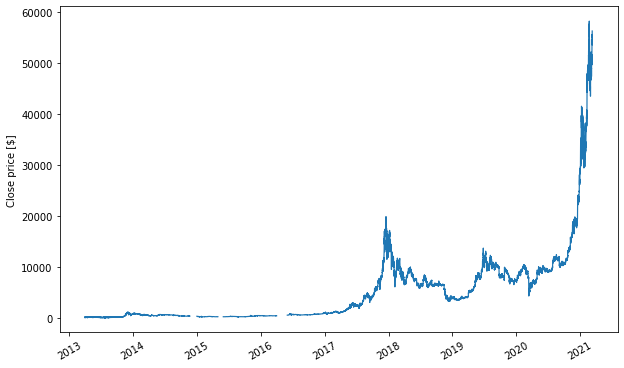

In [16]:
path_fig = 'C:/Users/Alberto/Desktop/Crypto prediction/Representations/btcusd/'

plt.figure(figsize=(10,6))

plt.plot(df.index, df['close'], linewidth=1.2, label='btc/usd')
plt.xticks(rotation='30')
plt.ylabel('Close price [$]')
#plt.savefig(path_fig + 'btc_close_2020.png')

### Define some indicators

#### Simple moving average (SMA)

In [17]:
df['sma_3h'] = df['close'].rolling(window='3h', center=False, min_periods=6).mean()

In [18]:
df['sma_6h'] = df['close'].rolling(window='6h', center=False, min_periods=12).mean()

In [19]:
df['sma_24h'] = df['close'].rolling(window='24h', center=False, min_periods=48).mean()

#### Exponential moving average (EMA)

In [20]:
df['ema_6h'] = df['close'].ewm(span=12, min_periods=12).mean()

#### Relative strenght index (RSI)

In [21]:
"""
Definition:
==========================================================

UNITS_OF_TIME = 12   # this value is tipically 14
RS = AVG_GAINS(UNITS_OF_TIME) / AVG_LOSSES(UNITS_OF_TIME)

RSI = 100 - 100 / (1 + RS)
"""
def diff(array):
    return array[1] - array[0]

def is_gain(array):
    return array > 0

def rsi_metric(array):
    if len(array) == 0:
        return np.nan
    else:
        gains = array[is_gain(array)]
        losses = array[is_gain(array) == False]
    
        len_gains = len(gains)
        len_losses = len(losses)
        
        if len_gains == 0:
            return 0
        else:
            exp_decay = np.exp(- np.arange(1, len_gains + 1 , 1) / len_gains)
            avg_gains = np.abs(np.mean(gains * exp_decay))
        
        if len_losses == 0:
            return 100
        else:
            exp_decay = np.exp(- np.arange(1, len_losses + 1, 1) / len_gains)
            avg_losses = np.abs(np.mean(losses * exp_decay))        
        
        rs = avg_gains / avg_losses
    
        return 100 - 100 / (1 + rs)

# close_variation
df['close_variation'] = df['close'].rolling(window=2, min_periods=2).apply(diff, raw=True)

# rsi
df['rsi'] = df['close_variation'].rolling(window=12, min_periods=12).apply(rsi_metric, raw=True)

#### KDJ

In [22]:
"""
For this indicator we need three lines: K, D and J.
Definition:
==========================================================
UNITS_OF_TIME = 12

lowest_price_list = # list of the lowest value in each win of UNITS_OF_TIME elements
highest_price_list = # list of the highest value in each win of UNITS_OF_TIME elements

rsv = (closing_price - lowest_price_list) / (highest_price_list - lowest_price_list)

K = # exponentially weighted moving average over rsv with center of mass (com) equals to 2
D = # exponentially weighted moving average over K with center of mass (com) equals to 2
J = 3 * K - 2 * D
"""
UNITS_OF_TIME = 12

lowest_price_list = df['low'].rolling(UNITS_OF_TIME, min_periods=UNITS_OF_TIME).min()
lowest_price_list.fillna(value = df['low'].expanding().min(), inplace = True)

highest_price_list = df['high'].rolling(UNITS_OF_TIME, min_periods=UNITS_OF_TIME).max()
highest_price_list.fillna(value = df['high'].expanding().max(), inplace = True)

rsv = (df['close'] - lowest_price_list) / (highest_price_list - lowest_price_list) * 100

df['K'] = pd.Series(rsv).ewm(com=2).mean()
df['D'] = df['K'].ewm(com=2).mean()
df['J'] = 3 * df['K'] - 2 * df['D']

#### Bollinger bands

In [23]:
"""
The Bollinger bands are two simple (or sometimes exponential) moving averages 
at a distance of k times the standard deviation over and below the s(e)ma.

As we have already calculated some sma, we just have to calculate the standard
deviation and plot both bands.
"""
ma_type = 'sma_3h'
k = 2 # custom parameter

df['upper_bb'] = df[ma_type] + k * df[ma_type].rolling(window=20, center=False, min_periods=6).std()
df['lower_bb'] = df[ma_type] - k * df[ma_type].rolling(window=20, center=False, min_periods=6).std()

#### KC channels

In [24]:
"""
The KC channels are the two lines we are going to use as delimeters of the
squeeze band. In order to calculate them we need the True Range (TR) for
each data point and the Average True Range (ATR). Then, we define this
channels as:

upper_kc = ema + k_kc * ATR
lower_kc = ema - k_kc * ATR
"""
win_size_kc = 12 # 12 for 'ema_6h', 24 for 'ema_12h', etc. Must be the same as bollinger bands.
k_kc = 1.5

df['TR'] = abs(df['high'] - df['low'])
df['ATR'] = df['TR'].rolling(window=win_size_kc).mean()

df['upper_kc'] = df[ma_type] + k_kc * df['ATR']
df['lower_kc'] = df[ma_type] - k_kc * df['ATR']

### Save formatted data

In [25]:
#df.to_csv(path_data + 'Formatted/btcusd_fmttd.csv')

##### Select one day data

In [26]:
df_day = df[df.index.date == datetime.date(2020, 10, 29)]

In [27]:
date = df_day.index.date[0].strftime("%Y/%m/%d")

#### Find overbought and oversold area limits in the selected period of time

In [28]:
"""
Overbought area: K > 80, D > 70, J > 90
Oversold area: K < 20, D < 30
"""

overbought_condition = (df_day['K'] > 80) & (df_day['D'] > 70) & (df_day['J'] > 90)
oversold_condition = (df_day['K'] < 20) & (df_day['D'] < 30)
    
def lims(array):
    lims = [[0,0]]
    for idx, value in enumerate(array):
        if (value == True) & (idx > lims[-1][-1]):
            index = idx + 1
            while index <= (len(array) - 1):
                if array[index] == True:
                    index += 1
                else:
                    break
            if idx < (index - 1):
                lims.append([idx, index-1])

    return lims[1:]

# Indexes of overbought and oversold limit areas
ob_lims_id = lims(overbought_condition.values)
os_lims_id = lims(oversold_condition.values)

# Time of overbought and oversold limit areas
ob_in_interval = df_day.index.values[np.isin(np.arange(len(df_day)), ob_lims_id)]
os_in_interval = df_day.index.values[np.isin(np.arange(len(df_day)), os_lims_id)]

### Plot

In [29]:
# Choose if plot Bollinger bands or not
plot_bb_bands = True

In [30]:
# Choose if plot KC channels or not
plot_kc_channels = True

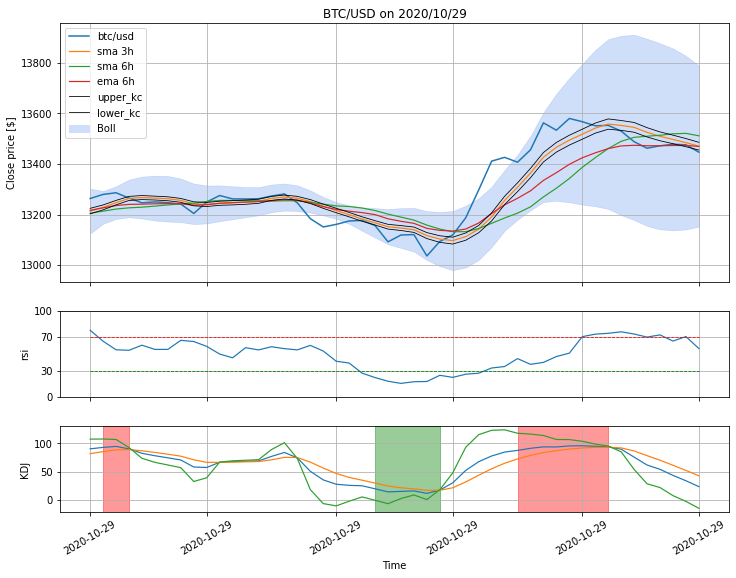

In [31]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12,9), gridspec_kw={'height_ratios': [3, 1, 1]})

plt.xticks(rotation='30')

# Plot BTC/USD graph and indicators: sma, ema
axes[0].plot(df_day.index, df_day['close'], linewidth=1.5, label='btc/usd')
axes[0].plot(df_day.index, df_day['sma_3h'], linewidth=1.2, label='sma 3h')
axes[0].plot(df_day.index, df_day['sma_6h'], linewidth=1.2, label='sma 6h')
axes[0].plot(df_day.index, df_day['ema_6h'], linewidth=1.2, label='ema 6h')

if plot_bb_bands:
    axes[0].fill_between(df_day.index, df_day['upper_bb'], df_day['lower_bb'],
                         color='cornflowerblue', alpha=0.3,
                         linewidth=0.6, label='Boll')
if plot_kc_channels:
    axes[0].plot(df_day.index, df_day['upper_kc'],
                 linewidth=0.8, color='black', label='upper_kc')
    axes[0].plot(df_day.index, df_day['lower_kc'],
                 linewidth=0.8, color='black', label='lower_kc')
    
axes[0].legend()
axes[0].set_ylabel('Close price [$]')
axes[0].set_title(f'BTC/USD on {date}')
axes[0].grid()

# Plot indicator: rsi
axes[1].plot(df_day.index, df_day['rsi'], linewidth=1.2, label='rsi')
axes[1].plot(df_day.index, [70] * len(df_day.index), 'r--', linewidth=0.8, label='overbought')
axes[1].plot(df_day.index, [30] * len(df_day.index), 'g--', linewidth=0.8, label='oversold')
axes[1].set_ylabel('rsi')
axes[1].set_ylim([0,100])
axes[1].set_yticks([0, 30, 70, 100])
axes[1].grid()

# Plot indicator: KDJ and overbought and oversold areas
axes[2].plot(df_day.index, df_day['K'], linewidth=1.2, label='K')
axes[2].plot(df_day.index, df_day['D'], linewidth=1.2, label='D')
axes[2].plot(df_day.index, df_day['J'], linewidth=1.2, label='J')
axes[2].set_ylabel('KDJ')
axes[2].set_xlabel('Time')
#axes[2].legend()
for lim in range(len(ob_in_interval)):
    if (lim % 2 == 0) & ((lim + 1) < (len(ob_in_interval))):
        axes[2].axvspan(ob_in_interval[lim], ob_in_interval[lim+1], color='red', alpha=0.4)
for lim in range(len(os_in_interval)):
    if (lim % 2 == 0) & ((lim + 1) < (len(os_in_interval))):
        axes[2].axvspan(os_in_interval[lim], os_in_interval[lim+1], color='green', alpha=0.4)

axes[2].set_xticks(df_day.index.values[np.round(np.linspace(0, len(df_day.index.values) - 1, 6)).astype(int)])
axes[2].grid()

#plt.savefig(path_fig + 'btcusd_indicators.png')